In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data

In [2]:
start = '2010-01-01'
end = '2019-12-31'

df = data.DataReader('GOLD','yahoo',start , end)
df=df.reset_index()

In [3]:
df=df.drop(['Date', 'Adj Close'], axis=1)


In [4]:
ma100 = df.Close.rolling(100).mean()
ma200 =df.Close.rolling(200).mean()

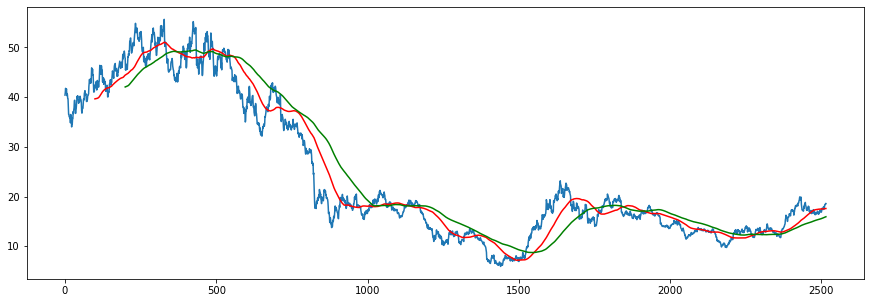

In [5]:
plt.figure(figsize=(15,5))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [6]:
train_ind = int(len(df)*0.8)
train = pd.DataFrame(df['Close'][:train_ind])
test = pd.DataFrame(df['Close'][train_ind:])
train.shape

(2012, 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
train_scaled = scaler.fit_transform(train)


In [9]:
x_train = []
y_train = []

for i in range(100,train_scaled.shape[0]):
    x_train.append(train_scaled[i-100:i])
    y_train.append(train_scaled[i,0])




In [10]:
x_train , y_train = np.array(x_train), np.array(y_train)



In [11]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
model = Sequential()
model.add(LSTM(units=64, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Dense(1))
optimiser = RMSprop(learning_rate=1e-3)

model.compile(optimizer=optimiser, loss='mean_squared_error')
model.fit(x_train, y_train, epochs =15)

2022-08-10 23:17:48.333935: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 23:17:48.334347: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 1912 samples
Epoch 1/15


2022-08-10 23:17:49.572208: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_2368_2550' and '__inference___backward_standard_lstm_2696_3181_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_3341' both implement 'lstm_5a1dc2bf-2d9f-45ad-bc9c-db91d9ceef50' but their signatures do not match.


1912/1912 [==============================] - 15s 8ms/sample - loss: 0.0158
Epoch 2/15
1912/1912 [==============================] - 13s 7ms/sample - loss: 0.0034
Epoch 3/15
1912/1912 [==============================] - 13s 7ms/sample - loss: 0.0027
Epoch 4/15
1912/1912 [==============================] - 13s 7ms/sample - loss: 0.0023
Epoch 5/15
1912/1912 [==============================] - 13s 7ms/sample - loss: 0.0020
Epoch 6/15
1912/1912 [==============================] - 13s 7ms/sample - loss: 0.0019
Epoch 7/15
1912/1912 [==============================] - 15s 8ms/sample - loss: 0.0016
Epoch 8/15
1912/1912 [==============================] - 17s 9ms/sample - loss: 0.0016
Epoch 9/15
1912/1912 [==============================] - 15s 8ms/sample - loss: 0.0013
Epoch 10/15
1912/1912 [==============================] - 31s 16ms/sample - loss: 0.0014
Epoch 11/15
1912/1912 [==============================] - 24s 13ms/sample - loss: 0.0014
Epoch 12/15
1912/1912 [==============================] - 22s 

In [12]:
model.save('keras_model.h5')

In [13]:
last_100_Days=train.tail(100)
final_df = last_100_Days.append(test, ignore_index=True)
final_df.head()

,Close
0,16.500000
1,16.730000
2,17.070000
3,17.040001
4,16.719999


In [14]:
input_data = scaler.fit_transform(final_df)


In [15]:
input_data.shape

(604, 1)

In [16]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i,0])

x_test, y_test = np.array(x_test), np.array(y_test)

print(x_test.shape, y_test.shape)

(504, 100, 1) (504,)


In [17]:
y_predicted_model= model.predict(x_test)

2022-08-10 23:22:15.499602: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_5395' and '__inference_standard_lstm_5395_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_5704' both implement 'lstm_ab8c8935-4d13-457b-b7bd-4fe772066f88' but their signatures do not match.


In [18]:
scaler.scale_

array([0.09823182])

In [19]:
scaler_factor = 1/0.09823182
y_predicted = y_predicted_model * scaler_factor
y_test = y_test * scaler_factor

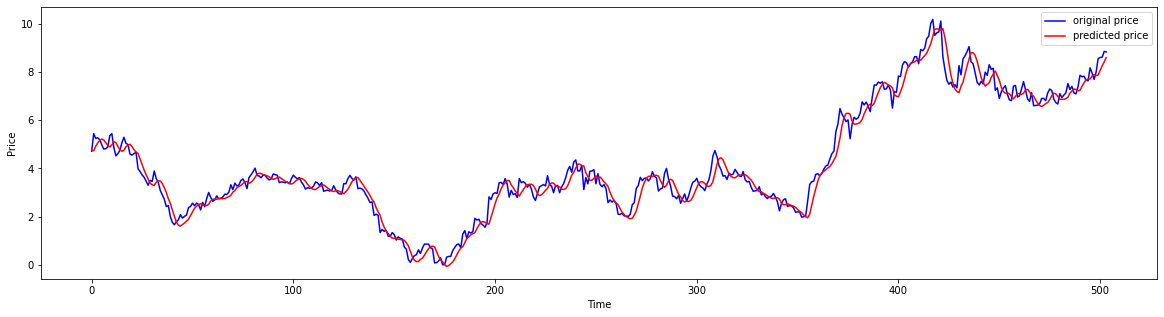

In [20]:
plt.figure(figsize=(20,5))
plt.plot(y_test, 'b', label='original price')
plt.plot(y_predicted, 'r', label='predicted price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()